## Transfer Style

<img src="https://shafeentejani.github.io/assets/images/fast_style_transfer/gatys_results.png">



- Example Based vs Collection Based
- Collection Based:
    - Paired
    - Unpaired
- Common Tool:
    GAN ( Generative Adversarial Networks)

<img src="https://cdn-images-1.medium.com/max/1000/1*fd3QUV45REqZ_f7tjYs31g.png">

## GANs
Architecture:
- Generative Network
- Discriminatory Network
- Zero-sum game (opposite losses)

<img src="https://pathmind.com/images/wiki/GANs.png">

## Loss of GANs
- Discriminatory Network: cross entropy when the network should reject
$$ L_{D} ~ -\log(D(x)) + -\log(1 - D(G(z))) $$
where $D(x) = \text{Real Data} \text{ and } D(z) = \text{Fake Data}$

- Generative Network: inverse of the discriminative (zero-sum game)
$$ L_{G} ~ C + \log(1 - D(G(z))) \text{ or } - \log(D(G(z))) $$

# CycleGAN

<img src="https://junyanz.github.io/CycleGAN/images/teaser.jpg">

### [Repository Source](https://github.com/aitorzip/PyTorch-CycleGAN)

[datasets - fix for windows](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/)

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd '/gdrive/My Drive'

/gdrive/My Drive


In [0]:
# !git clone https://github.com/aitorzip/PyTorch-CycleGAN.git


In [0]:
# %cd '/gdrive/My Drive/PyTorch-CycleGAN'

In [0]:

#%%sh
#sh ./download_dataset summer2winter_yosemite

In [0]:
# !mkdir datasets

In [0]:

#!mv datasets/summer2winter_yosemite /gdrive/My\ Drive/datasets/

In [0]:
#!ls /datasets/summer2winter_yosemite

In [0]:
#!ls /gdrive/My\ Drive/datasets/

In [0]:
import torch.nn as nn 
import torch.nn.functional as F 

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        conv_block = [
            nn.ReflectionPad2d(1), # Better Padding
            nn.Conv2d(in_features, in_features, 3), #Kernel_size = 3
            nn.InstanceNorm2d(in_features), # Contrast in images and regularization / BN for GANs
            nn.ReLU(True),
            nn.ReflectionPad2d(1), # preserves images distribution
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        ]
        
        self.conv_block = nn.Sequential(*conv_block)
        #self.conv_block = conv_block
        
    def forward(self, x):
        return self.conv_block(x) + x # Increase Models Space    
    

In [0]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc,  n_residual_blocks = 9):
        super(Generator, self).__init__()
        
        # Convolutional block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7), # I - 7(filter) + 6(2*padding) / 1 +1 = I
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
            
        ]
        
        
        in_features = 64
        out_features = in_features * 2  # Amount of channels
        
        # Encoding
        # Multiply by 2 number of channels
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2,padding=1 ), # I / 2
                nn.InstanceNorm2d(out_features), 
                nn.ReLU(True)
            ]
            
            in_features  = out_features
            out_features = in_features*2 
        
        # Residuals transforms
        
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)] # 9 Residual layers
        
        # Decoding
        out_features = in_features // 2
        
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3 , 
                                   stride=2, padding=1, output_padding=1), # 2I also Mat=gradient
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            
            in_features = out_features
            out_features = in_features // 2

        # output
        
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7), # I
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
        #self.model = model
        
    def forward(self, x):
        return self.model(x)


In [0]:
# PatchGAN

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        
        model = [
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1), # I / 2
            nn.LeakyReLU(0.2, inplace=True),
        ]
        
        model += [
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # I / 2
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        
        model += [
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # I / 2
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        
        model += [
            nn.Conv2d(256, 512, 4, padding=1), # I - 1
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        
        # Flatten
        
        model += [
            nn.Conv2d(512, 1, 4, padding=1) # I - 1 
        ]
        
        self.model = nn.Sequential(*model)
        #self.model = model
        
    def forward(self, x):
        x = self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)


In [0]:
import glob
import random
import os 
import itertools
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable


In [0]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [0]:
class ImageDataset(Dataset):
    def __init__(self, base_dir, transform=None, split='train'):
        print(os.path.join(base_dir))
        self.transform = transforms.Compose(transform)
        self.files_A = sorted(glob.glob(os.path.join(base_dir, '{}/A/*.*'.format(split))))
        self.files_B = sorted(glob.glob(os.path.join(base_dir, '{}/B/*.*'.format(split))))
        print(self.files_A)
        print(self.files_B)

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    
    def __getitem__(self, idx):
        image_A = self.transform(Image.open(self.files_A[idx]))
        image_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        return {'A': image_A, 'B':image_B}
    

In [0]:
epoch = 0      # Initial epoch
n_epochs = 200 # final epoch
batch_size = 2
lr = 0.0002

size = 256     # Img Size
input_nc = 3   # input channels
output_nc = 3  # Output channels
decay_epoch = 100

cuda = True # torch.cuda.is_available()
n_cpu = 8   # Pararel workers / CPU Threats

base_dir = '/gdrive/My Drive/datasets/' # Path

device = torch.device('cuda' if cuda else 'cpu')


In [0]:

# Inital params of NN
def weights_init_normal(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias, 0.0)

In [19]:
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(input_nc, output_nc) 
netD_A = Discriminator(input_nc)
netD_B = Discriminator(input_nc)


netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

print(cuda)

# To divice
if cuda:    
    netG_A2B.to(device)
    netG_B2A.to(device)
    netD_A.to(device)
    netD_B.to(device)


criterion_GAN  = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()


optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr,
                             betas=(0.5, 0.999))

optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5,0.999))


# Schedulers (update the learning rate dynamically during training)
class LambdaLR():
    def __init__(self, n_epoch, offset, decay_start_epoch):
        assert((n_epochs-decay_start_epoch) > 0 )
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
    
    def step(self, epoch):
        return 1 - max(0, epoch + self.offset - self.decay_start_epoch ) / (self.n_epochs - self.decay_start_epoch)
        


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """


True


In [ ]:
# Inputs and  Targets

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
#Tensor = torch.Tensor
target_real = Tensor(batch_size).fill_(1.0)
target_fake = Tensor(batch_size).fill_(0.0)


fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataloader

# Data Augmentation
transform = [transforms.Resize(int(size*1.12), Image.BICUBIC),
             transforms.RandomCrop(size),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ]
 
dataloader =  DataLoader(ImageDataset(base_dir, transform=transform), 
                        batch_size=batch_size, shuffle=True, 
                        num_workers=n_cpu, drop_last=True)


def Gen_GAN_loss(G, D, real, loss, target_real):
    fake = G(real) # Generative Network
    pred_fake = D(fake) # Discriminative network
    L = loss(pred_fake, target_real) # Calculate loss
    return L, fake # loss, fake
    
def cycle_loss(G1, G2, real, loss):
    recovered = G2(G1(real)) # cycle 
    L = loss(recovered, real)
    return L

def identity_loss(G, real, loss):
    same = G(real)
    L = loss(same, real)
    return L

def Disc_GAN_loss(D2, fake2, real2, fake_2_buffer, loss, target_real, target_fake):
    pred_real = D2(real2) # Real prediction
    loss_D2_real = loss(pred_real, target_real) # loss
    fake2 = fake_2_buffer.push_and_pop(fake2) # 
    pred_fake = D2(fake2.detach())
    loss_D2_fake = loss(pred_fake, target_fake)
    loss_D2 = (loss_D2_real + loss_D2_fake) * 0.5
    
    return loss_D2

In [21]:
!pip install livelossplot 

In [27]:
import time
import datetime
import sys
class Logger():
    def __init__(self, n_epochs, batches_epoch, epoch=1):
        self.n_epochs = n_epochs
        self.batches_epoch = batches_epoch
        self.epoch = epoch
        self.batch = 1
        self.prev_time = time.time()
        self.mean_period = 0
        self.losses = {}
        self.loss_windows = {}
        self.image_windows = {}


    def log(self, losses=None, images=None):
        self.mean_period += (time.time() - self.prev_time)
        self.prev_time = time.time()

        sys.stdout.write('\rEpoch %03d/%03d [%04d/%04d] -- ' % (self.epoch, self.n_epochs, self.batch, self.batches_epoch))

        for i, loss_name in enumerate(losses.keys()):
            if loss_name not in self.losses:
                self.losses[loss_name] = losses[loss_name].data.item()
            else:
                self.losses[loss_name] += losses[loss_name].data.item()
            
            if (i+1) == len(losses.keys()):
                sys.stdout.write('%s: %.4f -- ' % (loss_name, self.losses[loss_name]/self.batch))
            else:
                sys.stdout.write('%s: %.4f | ' % (loss_name, self.losses[loss_name]/self.batch))

        batches_done = self.batches_epoch*(self.epoch - 1) + self.batch
        batches_left = self.batches_epoch*(self.n_epochs - self.epoch) + self.batches_epoch - self.batch 
        
        try:
            sys.stdout.write('ETA: %s' % (datetime.timedelta(seconds=batches_left*self.mean_period/batches_done)))
        except:
            pass

        # End of epoch
        if (self.batch % self.batches_epoch) == 0:
            # Plot losses
            for loss_name, loss in self.losses.items():
                # Reset losses for next epoch
                self.losses[loss_name] = 0.0

            self.epoch += 1
            self.batch = 1
            sys.stdout.write('\n')
        else:
            self.batch += 1

SyntaxError: ignored

In [0]:
from livelossplot import PlotLosses
logger = Logger(n_epochs, len(dataloader), epoch=epoch)
liveloss= PlotLosses()

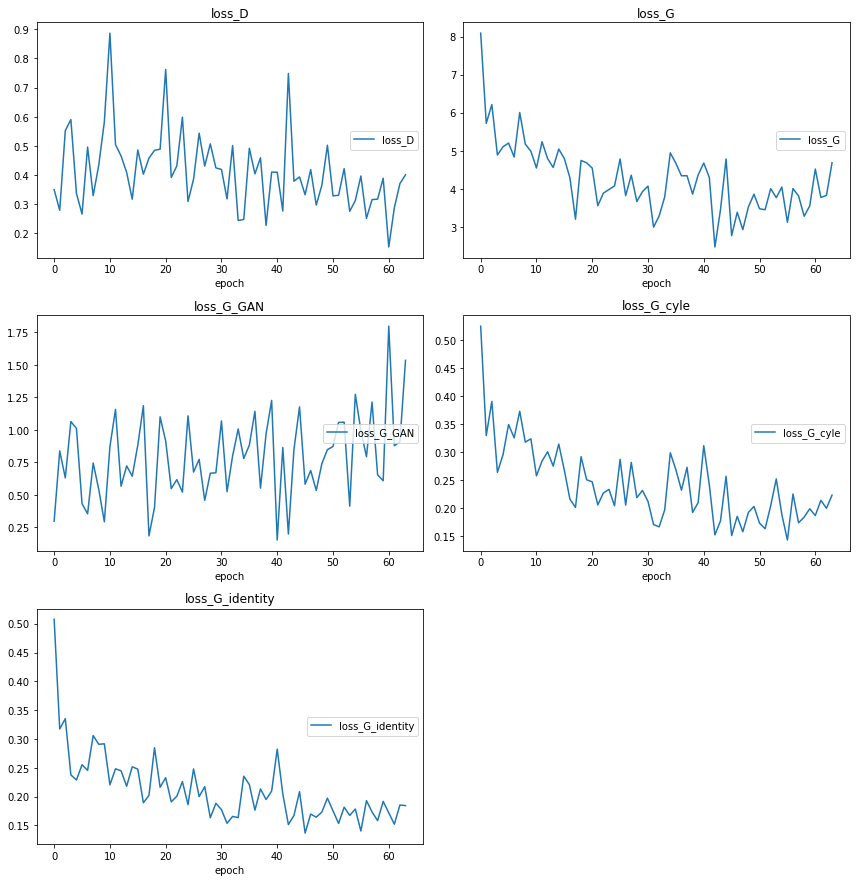

loss_D
	loss_D           	 (min:    0.153, max:    0.887, cur:    0.401)
loss_G
	loss_G           	 (min:    2.472, max:    8.091, cur:    4.685)
loss_G_GAN
	loss_G_GAN       	 (min:    0.152, max:    1.798, cur:    1.535)
loss_G_cyle
	loss_G_cyle      	 (min:    0.142, max:    0.525, cur:    0.223)
loss_G_identity
	loss_G_identity  	 (min:    0.137, max:    0.508, cur:    0.185)
64 / 200
Epoch 064/200 [0154/0615] -- loss_G: 3.6532 | loss_G_identity: 0.1700 | loss_G_GAN: 0.9770 | loss_G_cyle: 0.1826 | loss_D: 0.3099 -- ETA: 20:45:55.861063

In [0]:
for epoch in range(epoch, n_epochs):
    print(f'{epoch} / {n_epochs}')
    for i, batch in enumerate(dataloader):
        #print(i, type(i))
        #print(batch, type(batch))
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)
        
        #real_A = batch['A']
        #real_B = batch['B']
        
        # Generative
        
        optimizer_G.zero_grad()
        loss_GAN_A2B, fake_B = Gen_GAN_loss(netG_A2B, netD_B, real_A, criterion_GAN, target_real)
        loss_GAN_B2A, fake_A = Gen_GAN_loss(netG_B2A, netD_A, real_B, criterion_GAN, target_real)
        
        loss_cycle_ABA = cycle_loss(netG_A2B,netG_B2A, real_A, criterion_cycle)
        loss_cycle_BAB = cycle_loss(netG_B2A,netG_A2B, real_B, criterion_cycle)
        
        loss_identity_A = identity_loss(netG_B2A, real_A, criterion_identity)
        loss_identity_B = identity_loss(netG_A2B, real_B, criterion_identity)
        
        loss_G = (loss_GAN_A2B + loss_GAN_B2A) + 10.0*(loss_cycle_ABA + loss_cycle_BAB) + 5.0 * (loss_identity_A + loss_identity_B) 
        loss_G.backward()
        
        optimizer_G.step()
        
        # Discriminatory
        optimizer_D_A.zero_grad()
        loss_D_A = Disc_GAN_loss(netD_A, fake_A, real_A, fake_A_buffer, criterion_GAN, target_real, target_fake) 
        loss_D_A.backward()
        
        optimizer_D_A.step()
        
        
        optimizer_D_B.zero_grad()
        loss_D_B = Disc_GAN_loss(netD_B, fake_B, real_B, fake_B_buffer, criterion_GAN, target_real, target_fake) 
        loss_D_B.backward()
        
        optimizer_D_B.step()
        
        log_values = {'loss_G': loss_G,
                      'loss_G_identity': (loss_identity_A + loss_identity_B),
                      'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                      'loss_G_cyle': loss_cycle_ABA + loss_cycle_BAB,
                      'loss_D': loss_D_A + loss_D_B
                 }
        logger.log(log_values, images={'real_A': real_A,'real_B': real_B, 'fake_A': fake_A,'fake_B': fake_B  })
        
    liveloss.update(log_values)
    liveloss.draw()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
        
        
        
        

In [0]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

PATH = '/gdrive/My Drive/NA.pth'
PATH = '/gdrive/My Drive/NB.pth'
PATH = '/gdrive/My Drive/ND_A.pth'
PATH = '/gdrive/My Drive/ND_B.pth'
torch.save(netG_A2B, PATH)
torch.save(netG_B2A, PATH)
torch.save(netD_A, PATH)
torch.save(netD_B, PATH)

In [0]:

#netG_A2B = Generator(input_nc, output_nc)
#netG_B2A = Generator(input_nc, output_nc)
#netD_A = Discriminator(input_nc)
#netD_B = Discriminator(input_nc)


#model = Generator(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()